# 5. Univariate Analysis

### 5.1 Gene Feature Univariate Analysis

Since Gene is a Categorical Feature, we need to convert it to numerical vector. Otherwise, machine learning cannot be applied. So to featurize categorical features there are two popular methods:
1. One Hot Encoding
2. Response Coding or Mean Value Replacement

We will choose appropriate Featurization technique based on Machine Learning model we use. For multi-class calssification with categorical features One Hot Encoding works well for Logistic Regression, Linear Regression, Support Vector Machines while Response Coding works well for Naive Bayes, Random Forest.

In [2]:
import import_ipynb
from Preprocessing import *

In [3]:
# Functions for Response Coding with Laplace smoothing.

# Get Gene Feature Dictionary
def gene_variation_dict(alpha, feature, df):
    value_count = x_train[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        gv_dict[i]=vec
    return gv_dict

# Get Gene Feature
def gene_variation_feature(alpha, feature, df):
    gv_dict = gene_variation_dict(alpha, feature, df)
    value_count = x_train[feature].value_counts()
    gv_fea = []

    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])  
    return gv_fea

In [4]:
unique_genes = x_train['Gene'].value_counts()
print('Number of Unique Genes in Train Data :', unique_genes.shape[0])
print(unique_genes.head())       # Top frequently occuring genes

Number of Unique Genes in Train Data : 229
BRCA1    164
TP53      98
EGFR      96
BRCA2     81
PTEN      77
Name: Gene, dtype: int64


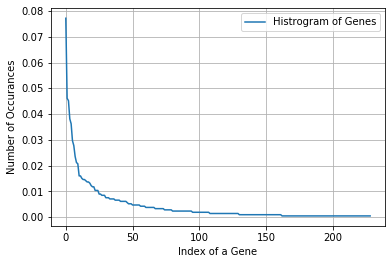

In [5]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

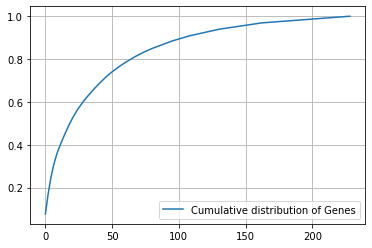

In [6]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

From the cumulative distribution graph of genes we see that the first 50 genes contribute almost 75% of the total categories.

#### 5.1.1 Response Coding of the Gene feature

In [7]:
# alpha is used for laplace smoothing

alpha = 1
train_gene_feature_responseCoding = np.array(gene_variation_feature(alpha, "Gene", x_train))    # train gene feature
test_gene_feature_responseCoding = np.array(gene_variation_feature(alpha, "Gene", x_test))      # test gene feature
cv_gene_feature_responseCoding = np.array(gene_variation_feature(alpha, "Gene", x_cv))          # cross validation gene feature

In [8]:
print("train_gene_feature_responseCoding is converted feature using respone coding method.")
print("The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method.
The shape of gene feature: (2124, 9)


#### 5.1.2 One hot Enoding of the Gene feature

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [11]:
x_train['Gene'].head()

805     ERCC2
2832    BRCA2
605     SMAD4
869     HLA-A
2858    BRCA2
Name: Gene, dtype: object

In [12]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method.")
print("The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method.
The shape of gene feature: (2124, 228)


In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

For values of alpha =  1e-05 The log loss is: 1.2115772481508051
For values of alpha =  0.0001 The log loss is: 1.19088227899019
For values of alpha =  0.001 The log loss is: 1.2368675102752964
For values of alpha =  0.01 The log loss is: 1.3572223671360073
For values of alpha =  0.1 The log loss is: 1.460309802778397
For values of alpha =  1 The log loss is: 1.4985820220768058


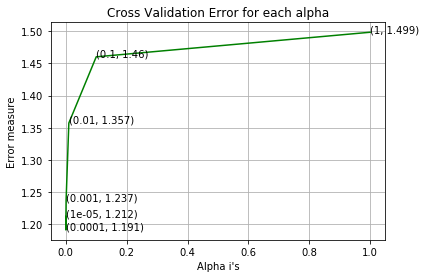

For values of best alpha =  0.0001 The train log loss is: 0.9750381264735285
For values of best alpha =  0.0001 The cross validation log loss is: 1.19088227899019
For values of best alpha =  0.0001 The test log loss is: 1.2305905609360253


In [14]:
alpha = [10 ** x for x in range(-5, 1)]      # Hyperparameter for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Since the Train, Cross-Validation and Test errors, using only the Gene Feature, are less than the log-loss of the random model, Gene Feature is an important feature. And since the Cross-Validation and Test errors are almost same as the Train errors, this model is quite stable (i.e. we are not overfitting the model).

In [15]:
print("How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage = x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage = x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of', x_test.shape[0], ":", (test_coverage/x_test.shape[0])*100, "%")
print('2. In cross validation data',cv_coverage, 'out of ', x_cv.shape[0],":" , (cv_coverage/x_cv.shape[0])*100, "%")

How many data points in Test and CV datasets are covered by the  229  genes in train dataset?
Ans
1. In test data 636 out of 665 : 95.6390977443609 %
2. In cross validation data 509 out of  532 : 95.67669172932331 %


### 5.2 Variation/Mutation Feature Univariate Analysis

Since Variation is also a Categorical Feature, we need to convert it to numerical vector. Otherwise, machine learning cannot be applied.

In [16]:
unique_variations = x_train['Variation'].value_counts()
print('Number of Unique Variations in Train Data :', unique_variations.shape[0])
print(unique_variations.head())                  # Top frequently occuring variations

Number of Unique Variations in Train Data : 1928
Truncating Mutations    64
Deletion                50
Amplification           38
Fusions                 19
Overexpression           4
Name: Variation, dtype: int64


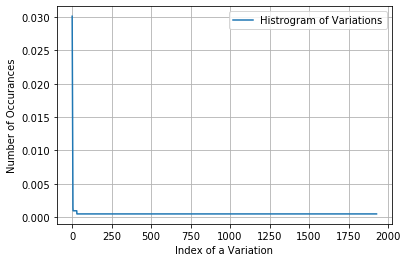

In [17]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

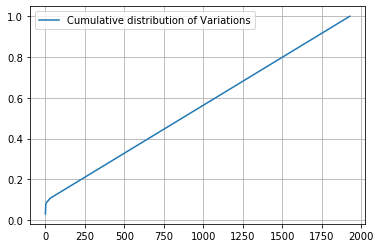

In [18]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

From the Histogram of variations we see that the most of the variations occur twice or thrice (least number of times).

#### 5.2.1 Response Coding of the Variation feature

In [19]:
# alpha is used for laplace smoothing

alpha = 1
train_variation_feature_responseCoding = np.array(gene_variation_feature(alpha, "Variation", x_train))    # train variation feature
test_variation_feature_responseCoding = np.array(gene_variation_feature(alpha, "Variation", x_test))      # test variation feature
cv_variation_feature_responseCoding = np.array(gene_variation_feature(alpha, "Variation", x_cv))          # cross validation variation feature

In [20]:
print("train_variation_feature_responseCoding is converted feature using respone coding method.")
print("The shape of variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is converted feature using respone coding method.
The shape of variation feature: (2124, 9)


#### 5.2.2 One hot Enoding of the Variation feature

In [21]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [22]:
x_train['Variation'].head()

805                    A717G
2832                   N588D
605                    D351H
869     Truncating Mutations
2858                  D2665G
Name: Variation, dtype: object

In [23]:
print("train_variation_feature_onehotCoding is converted feature using one-hot encoding method.")
print("The shape of variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotCoding is converted feature using one-hot encoding method.
The shape of variation feature: (2124, 1958)


For values of alpha =  1e-05 The log loss is: 1.7211972790499364
For values of alpha =  0.0001 The log loss is: 1.7137559911106484
For values of alpha =  0.001 The log loss is: 1.7186393949509091
For values of alpha =  0.01 The log loss is: 1.7318626830070882
For values of alpha =  0.1 The log loss is: 1.74891540241752
For values of alpha =  1 The log loss is: 1.7497345933390887


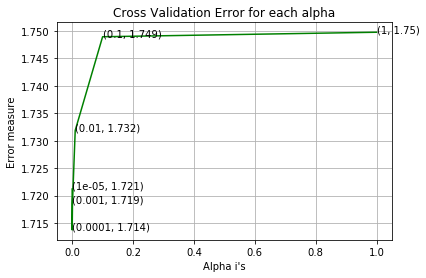

For values of best alpha =  0.0001 The train log loss is: 0.6790300796200863
For values of best alpha =  0.0001 The cross validation log loss is: 1.7137559911106484
For values of best alpha =  0.0001 The test log loss is: 1.714376243380602


In [24]:
alpha = [10 ** x for x in range(-5, 1)]      # Hyperparameter for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


The Train, Cross-Validation and Test errors, using only the Variation Feature, are less than the log-loss of the random model, Variation Feature is an important feature. And since the Cross-Validation and Test errors are quite separate from the Train errors, this model may be unstable (i.e. we are overfitting the model). But we cannot be sure from this result. So lets be sure by perfo

In [25]:
print("How many data points in Test and CV datasets are covered by the ", unique_variations.shape[0], " variations in train dataset?")

test_coverage = x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage = x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]

print('\n1. In test data',test_coverage, 'out of', x_test.shape[0], ":", (test_coverage/x_test.shape[0])*100, "%")
print('2. In cross validation data',cv_coverage, 'out of ', x_cv.shape[0],":" , (cv_coverage/x_cv.shape[0])*100, "%")

How many data points in Test and CV datasets are covered by the  1928  variations in train dataset?

1. In test data 71 out of 665 : 10.676691729323307 %
2. In cross validation data 51 out of  532 : 9.586466165413533 %


Of the total points present in the train data, only 10% (roughly) data points are present in the test and cross-validation data. So the system is unstable. To prevent overfitting of the model, we need to work well on the Variation Feature.

### 5.3 Text Feature Univariate Analysis

Here, cls_text is a dataframe. For every row in dataframe, we consider the 'TEXT' and split the words by space. Then we will make a dictionary with those words and increase its count whenever we see that word.

In [26]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

#### 5.3.1 Response Coding of the Text feature

In [27]:
import math
from sklearn.preprocessing import normalize
from collections import Counter, defaultdict

In [28]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [29]:
text_vectorizer = CountVectorizer(min_df=3)                                      # Take only those words that occured at least 3 times
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['Text'])
train_text_features= text_vectorizer.get_feature_names()                         # Get all the feature names (words)
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1           # sum every row and returns (1*number of features) vector
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))       # Zip a word with number of times it occured

print("Number of Unique Words in Train Data:", len(train_text_features))

Number of Unique Words in Train Data: 53818


In [30]:
dict_list = []                     # dict_list contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]                # Build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))  # Append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [31]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

Now lets normalize the result to convert each row values such that they sum to 1

In [32]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

#### 5.3.2 One Hot Encoding of the Text feature

In [33]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['Text'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)   # Normalize every feature

cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['Text'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)       # Normalize every feature

In [34]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

print(Counter(sorted_text_occur))       # Number of words for a given frequency.

Counter({3: 4928, 4: 3900, 5: 3155, 6: 2953, 8: 1962, 10: 1850, 7: 1743, 9: 1710, 12: 1373, 11: 1035, 15: 976, 13: 972, 14: 848, 16: 773, 17: 743, 18: 700, 20: 630, 21: 585, 24: 522, 19: 483, 22: 447, 30: 427, 27: 413, 28: 398, 25: 380, 23: 371, 26: 339, 43: 337, 32: 302, 29: 289, 36: 274, 49: 270, 33: 270, 31: 250, 42: 246, 40: 246, 44: 236, 34: 236, 39: 220, 35: 213, 38: 205, 37: 202, 47: 192, 41: 192, 45: 182, 50: 175, 48: 165, 46: 155, 60: 153, 54: 151, 51: 146, 59: 145, 52: 141, 57: 135, 56: 126, 53: 124, 63: 123, 66: 120, 88: 119, 55: 118, 64: 114, 61: 109, 58: 109, 65: 106, 72: 105, 69: 105, 68: 101, 62: 95, 78: 92, 73: 91, 80: 89, 84: 85, 67: 82, 74: 81, 70: 80, 77: 78, 76: 78, 79: 76, 91: 75, 81: 75, 105: 73, 98: 72, 71: 72, 89: 70, 75: 70, 82: 69, 92: 67, 90: 67, 85: 66, 83: 66, 97: 62, 93: 62, 87: 62, 100: 57, 94: 57, 112: 55, 86: 55, 96: 54, 117: 52, 120: 51, 106: 51, 102: 51, 132: 50, 115: 50, 111: 50, 110: 50, 99: 50, 113: 49, 103: 49, 131: 48, 124: 48, 133: 47, 123: 47, 

For values of alpha =  1e-05 The log loss is: 1.4591866204461084
For values of alpha =  0.0001 The log loss is: 1.3896159336145177
For values of alpha =  0.001 The log loss is: 1.3569722435233884
For values of alpha =  0.01 The log loss is: 1.4963105136117327
For values of alpha =  0.1 The log loss is: 1.6085163864472576
For values of alpha =  1 The log loss is: 1.7312334621672385


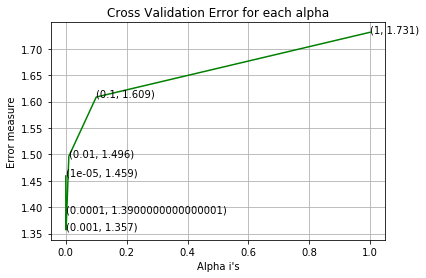

For values of best alpha =  0.001 The train log loss is: 0.6442087383941061
For values of best alpha =  0.001 The cross validation log loss is: 1.3569722435233884
For values of best alpha =  0.001 The test log loss is: 1.2153693600854432


In [35]:
alpha = [10 ** x for x in range(-5, 1)]      # Hyperparameter for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The Train, Cross-Validation and Test errors, using only the Variation Feature, are less than the log-loss of the random model, Variation Feature is an important feature. And since the Cross-Validation and Test errors are almost same as the Train errors, this model may be stable (i.e. we are not overfitting the model). But we cannot be sure from this result. So lets be sure by performing below operation:

In [36]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features), df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [37]:
len1,len2 = get_intersec_text(x_test)
print(len2, "out of", len1, ":", np.round((len2/len1)*100, 3), "% words appeared in Test data that were present in the train data")
len1,len2 = get_intersec_text(x_cv)
print(len2, "out of", len1, ":", np.round((len2/len1)*100, 3), "% words appeared in CV data that were present in the train data")

27744 out of 28901 : 95.997 % words appeared in Test data that were present in the train data
24870 out of 25469 : 97.648 % words appeared in CV data that were present in the train data


Of the total points present in the train data, only 97% (roughly) data points are present in the test and cross-validation data. So the system is stable. So this feature is of high importance and has low risk of overfitting.